In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaModel, AdamW
from transformers import RobertaTokenizer
import torch.optim as optim
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
import numpy as np
import os

2023-10-11 14:16:04.377463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class BertAtt(nn.Module):
    def __init__(self, d_e, h):
        super(BertAtt, self).__init__()
        self.num_heads = h
        self.d_e = d_e
        self.head_dim = d_e // h
        
        self.q = nn.Linear(d_e, d_e)
        self.k = nn.Linear(d_e, d_e)
        self.v = nn.Linear(d_e, d_e)
        
        self.o = nn.Linear(d_e, d_e)
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        Q = self.q(x)
        K = self.k(x)
        V = self.v(x)
        
        Q = Q.view(Q.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(K.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(V.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        
        attention_scores = torch.matmul(Q, K.permute(0, 1, 3, 2)) / (self.d_e**0.5)
        attention_probs = F.softmax(attention_scores, dim=-1)
        context = torch.matmul(attention_probs, V)
        
        context = context.permute(0, 2, 1, 3).contiguous()
        context = context.view(context.size(0), -1, self.num_heads*self.head_dim)
        context = self.dropout(context)
        context = self.o(context)
        
        return self.layer_norm(x + context)

class HBN(nn.Module):
    def __init__(self, d_e, h, m, n, y, dropout_prob=0.01, max_sentences=114):
        super(HBN, self).__init__()
        
        # Token-level Roberta encoder
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        
        # Freeze Roberta weights
        for param in self.roberta.parameters():
            param.requires_grad = False
        
        # Sentence-level BERT Encoder
        self.bertatt = BertAtt(d_e, h)
        
        self.ff = nn.Sequential(
            nn.Linear(d_e, n*d_e),
            nn.ReLU(),
            nn.Linear(n*d_e, d_e)
        )
        self.layer_norm = nn.LayerNorm(d_e)
        
        self.multiple_bert_layers = nn.ModuleList([BertAtt(d_e, h) for _ in range(m)])
        
        self.transformation = nn.Linear(d_e, d_e)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        # Prediction Layer
        self.predict = nn.Linear(d_e, y)
        
    def forward(self, input_ids, attention_mask):
#         print(input_ids.shape)
        # Token-level Roberta encoding
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[0]  # [batch_size, seq_length, hidden_size]
        
        # Average pooling to get sentence embeddings
        D = torch.mean(roberta_outputs, dim=1)  # [batch_size, hidden_size]
        
        out = self.bertatt(D)
        out = self.layer_norm(out + F.relu(self.ff(out)))
        
        Z = out
        for layer in self.multiple_bert_layers:
            Z = layer(Z)
        
        S = torch.tanh(torch.mean(Z, dim=1).mm(self.transformation.weight))
        S = self.dropout(S)
        scores = S.mm(self.predict.weight.t())
        
        return scores


In [3]:
# Parameters
d_e = 768  # Assuming you are using 'roberta-base'
h = 1     # Number of attention heads
m = 4      # Number of identical BERT layers
n = 4      # Scaling factor for feed-forward network
y = 2      # Number of classes, set this to your actual number
dropout_prob = 0.01 #dropout probability
num_train_samples = 200
num_epochs = 50
max_length = 128

In [4]:
import os
import pandas as pd
from nltk.tokenize import sent_tokenize

folder1_path = 'sample-text/sample-text/politics/'
folder2_path = 'sample-text/sample-text/business/'

# Fetch file names from both folders
folder1_files = [f for f in os.listdir(folder1_path) if f.endswith('.txt')]
folder2_files = [f for f in os.listdir(folder2_path) if f.endswith('.txt')]

combined_data = []
num_sent=[]

# Read and label files from folder1 and count sentences
for file in folder1_files:
    with open(os.path.join(folder1_path, file), 'r') as f:
        content = f.read()
        num_sentences = len(sent_tokenize(content))
        combined_data.append((content, 0))
        num_sent.append(num_sentences)

# Read and label files from folder2 and count sentences
for file in folder2_files:
    with open(os.path.join(folder2_path, file), 'r') as f:
        content = f.read()
        num_sentences = len(sent_tokenize(content))
        combined_data.append((content, 1))
        num_sent.append(num_sentences)

# Convert combined_data to DataFrame
df = pd.DataFrame(combined_data, columns=['content', 'label'])

# Shuffle the DataFrame
data = df.sample(frac=1).reset_index(drop=True)

# Display the shuffled DataFrame
print(data)

# Find out the maximum number of sentences across all files
max_sentences = max(num_sent)
print(f"\nMaximum number of sentences across all files: {max_sentences}")


                                               content  label
0    Donor attacks Blair-Brown 'feud'\n\nThe report...      0
1    Kennedy looks to election gains\n\nThey may no...      0
2    Assembly ballot papers 'missing'\n\nHundreds o...      0
3    Howard rebuts asylum criticisms\n\nTory leader...      0
4    Palestinian economy in decline\n\nDespite a sh...      1
..                                                 ...    ...
593  BP surges ahead on high oil price\n\nOil giant...      1
594  Borders rail link campaign rally\n\nCampaigner...      0
595  GSK aims to stop Aids profiteers\n\nOne of the...      1
596  Clarke defends terror detentions\n\nThe home s...      0
597  Commons hunt protest charges\n\nEight proteste...      0

[598 rows x 2 columns]

Maximum number of sentences across all files: 248


In [5]:
# len(test_indices),len(train_indices),len(val_indices)

In [6]:
# len(reviews_sentences)

In [7]:
# 2. Split data into train, validation, and test samples
num_train_samples = num_train_samples
num_val_samples = int(0.2 * num_train_samples)
train_data = data.iloc[:num_train_samples]
val_data = data.iloc[num_train_samples:num_train_samples+num_val_samples]
test_data = data.iloc[num_train_samples+num_val_samples:]

# 3. Preprocess and Flatten
def preprocess_and_flatten(dataframe):
    reviews = dataframe['content'].tolist()
    labels = dataframe['label'].tolist()
    reviews = [review.lower() for review in reviews]
    reviews_sentences = [sent_tokenize(review) for review in reviews]
    flattened_reviews = [sentence for review in reviews_sentences for sentence in review]
    flattened_labels = [label for review, label in zip(reviews_sentences, labels) for sentence in review]
    return flattened_reviews, flattened_labels

train_reviews, train_labels = preprocess_and_flatten(train_data)
val_reviews, val_labels = preprocess_and_flatten(val_data)
test_reviews, test_labels = preprocess_and_flatten(test_data)

# 4. Tokenization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_tokens = tokenizer(train_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
val_tokens = tokenizer(val_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)
test_tokens = tokenizer(test_reviews, padding=True, truncation=True, return_tensors="pt", max_length=max_length)

# 5. Create DataLoader
train_batch_size = 4
val_batch_size = 4
test_batch_size = 4

train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], torch.tensor(train_labels))
val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'], torch.tensor(val_labels))
test_dataset = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=val_batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

# Uncomment to test: iterating over the DataLoader
for batch in train_loader:
    input_ids, attention_mask, labels = batch
    print(input_ids.shape, attention_mask.shape, labels.shape)
len(train_loader.dataset),len(val_loader.dataset),len(test_loader.dataset)

torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4, 128]) torch.Size([4, 128]) torch.Size([4])
torch.Size([4,

(3596, 1044, 6128)

In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = HBN(d_e, h, m, n, y, dropout_prob).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def train(model, dataloader, optimizer, criterion, device, epoch):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids, attention_mask, labels = batch
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
            
            # For AUC
            # Assuming binary classification; you need to get the probabilities for the positive class
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    auc = roc_auc_score(all_labels, all_preds)
    return total_loss / len(dataloader), accuracy, auc



In [10]:
# Actual Training Loop
train_loss_epoch = []
test_loss_epoch = []
auc = []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    print(f"Train Loss: {train_loss:.4f}")
    val_loss, val_accuracy, val_auc = evaluate(model, val_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")
    train_loss_epoch.append(train_loss)
    test_loss_epoch.append(val_loss)
    auc.append(val_auc)

Epoch 1/50: 100%|█████████████████████████████████████████████████████████████████████| 899/899 [02:49<00:00,  5.30it/s]


Train Loss: 0.4094


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:41<00:00,  6.30it/s]


Val Loss: 0.5620, Val Accuracy: 0.7308, Val AUC: 0.9544


Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████| 899/899 [02:49<00:00,  5.29it/s]


Train Loss: 0.2832


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.85it/s]


Val Loss: 0.2640, Val Accuracy: 0.9128, Val AUC: 0.9503


Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████████| 899/899 [03:06<00:00,  4.82it/s]


Train Loss: 0.2664


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:27<00:00,  9.58it/s]


Val Loss: 0.2567, Val Accuracy: 0.9119, Val AUC: 0.9478


Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████████| 899/899 [02:35<00:00,  5.77it/s]


Train Loss: 0.2417


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:32<00:00,  8.10it/s]


Val Loss: 0.2356, Val Accuracy: 0.9148, Val AUC: 0.9476


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████| 899/899 [03:36<00:00,  4.14it/s]


Train Loss: 0.2406


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:25<00:00, 10.08it/s]


Val Loss: 0.2555, Val Accuracy: 0.9080, Val AUC: 0.9473


Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████| 899/899 [02:29<00:00,  6.00it/s]


Train Loss: 0.2383


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.73it/s]


Val Loss: 0.2360, Val Accuracy: 0.9004, Val AUC: 0.9491


Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████████| 899/899 [03:06<00:00,  4.82it/s]


Train Loss: 0.2234


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:28<00:00,  9.12it/s]


Val Loss: 0.2465, Val Accuracy: 0.9080, Val AUC: 0.9464


Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████████| 899/899 [03:28<00:00,  4.32it/s]


Train Loss: 0.2203


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:31<00:00,  8.35it/s]


Val Loss: 0.3322, Val Accuracy: 0.8688, Val AUC: 0.9443


Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████████| 899/899 [03:24<00:00,  4.40it/s]


Train Loss: 0.2178


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:25<00:00, 10.08it/s]


Val Loss: 0.2619, Val Accuracy: 0.8994, Val AUC: 0.9387


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [03:03<00:00,  4.90it/s]


Train Loss: 0.2126


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:36<00:00,  7.14it/s]


Val Loss: 0.2612, Val Accuracy: 0.8937, Val AUC: 0.9348


Epoch 11/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [03:13<00:00,  4.65it/s]


Train Loss: 0.2044


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:37<00:00,  7.00it/s]


Val Loss: 0.2802, Val Accuracy: 0.8860, Val AUC: 0.9348


Epoch 12/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:26<00:00,  6.14it/s]


Train Loss: 0.2135


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.88it/s]


Val Loss: 0.2931, Val Accuracy: 0.8860, Val AUC: 0.9317


Epoch 13/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:26<00:00,  6.15it/s]


Train Loss: 0.2051


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:25<00:00, 10.09it/s]


Val Loss: 0.2678, Val Accuracy: 0.8994, Val AUC: 0.9323


Epoch 14/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:29<00:00,  6.00it/s]


Train Loss: 0.2050


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.71it/s]


Val Loss: 0.3120, Val Accuracy: 0.8831, Val AUC: 0.9246


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:33<00:00,  5.87it/s]


Train Loss: 0.1975


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:27<00:00,  9.60it/s]


Val Loss: 0.2856, Val Accuracy: 0.8956, Val AUC: 0.9276


Epoch 16/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:33<00:00,  5.84it/s]


Train Loss: 0.1930


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:28<00:00,  9.32it/s]


Val Loss: 0.2844, Val Accuracy: 0.8831, Val AUC: 0.9327


Epoch 17/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:34<00:00,  5.84it/s]


Train Loss: 0.1972


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.67it/s]


Val Loss: 0.2781, Val Accuracy: 0.9004, Val AUC: 0.9280


Epoch 18/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:32<00:00,  5.90it/s]


Train Loss: 0.1907


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.72it/s]


Val Loss: 0.3102, Val Accuracy: 0.8985, Val AUC: 0.9245


Epoch 19/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:31<00:00,  5.92it/s]


Train Loss: 0.1872


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.69it/s]


Val Loss: 0.3183, Val Accuracy: 0.8860, Val AUC: 0.9282


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:33<00:00,  5.85it/s]


Train Loss: 0.1859


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:25<00:00, 10.12it/s]


Val Loss: 0.3332, Val Accuracy: 0.8822, Val AUC: 0.9240


Epoch 21/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:25<00:00,  6.18it/s]


Train Loss: 0.1826


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00, 10.00it/s]


Val Loss: 0.3110, Val Accuracy: 0.8985, Val AUC: 0.9341


Epoch 22/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:26<00:00,  6.13it/s]


Train Loss: 0.1883


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:25<00:00, 10.06it/s]


Val Loss: 0.3446, Val Accuracy: 0.8726, Val AUC: 0.9232


Epoch 23/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:25<00:00,  6.20it/s]


Train Loss: 0.1901


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:25<00:00, 10.05it/s]


Val Loss: 0.2808, Val Accuracy: 0.8908, Val AUC: 0.9299


Epoch 24/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:26<00:00,  6.15it/s]


Train Loss: 0.1795


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.92it/s]


Val Loss: 0.2927, Val Accuracy: 0.8975, Val AUC: 0.9294


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:25<00:00,  6.17it/s]


Train Loss: 0.1796


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:25<00:00, 10.05it/s]


Val Loss: 0.2981, Val Accuracy: 0.8994, Val AUC: 0.9348


Epoch 26/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:25<00:00,  6.18it/s]


Train Loss: 0.1765


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:25<00:00, 10.14it/s]


Val Loss: 0.3927, Val Accuracy: 0.8496, Val AUC: 0.9324


Epoch 27/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:45<00:00,  5.43it/s]


Train Loss: 0.1737


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.79it/s]


Val Loss: 0.2960, Val Accuracy: 0.8851, Val AUC: 0.9276


Epoch 28/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:25<00:00,  6.18it/s]


Train Loss: 0.1677


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.90it/s]


Val Loss: 0.2880, Val Accuracy: 0.8956, Val AUC: 0.9315


Epoch 29/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:44<00:00,  5.48it/s]


Train Loss: 0.1668


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:25<00:00, 10.08it/s]


Val Loss: 0.3595, Val Accuracy: 0.8774, Val AUC: 0.9256


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:25<00:00,  6.16it/s]


Train Loss: 0.1716


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.92it/s]


Val Loss: 0.4304, Val Accuracy: 0.8554, Val AUC: 0.9304


Epoch 31/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:25<00:00,  6.17it/s]


Train Loss: 0.1633


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:25<00:00, 10.05it/s]


Val Loss: 0.3347, Val Accuracy: 0.8803, Val AUC: 0.9251


Epoch 32/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:48<00:00,  5.32it/s]


Train Loss: 0.1657


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:39<00:00,  6.62it/s]


Val Loss: 0.3394, Val Accuracy: 0.8803, Val AUC: 0.9331


Epoch 33/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [03:12<00:00,  4.66it/s]


Train Loss: 0.1640


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:25<00:00, 10.13it/s]


Val Loss: 0.3985, Val Accuracy: 0.8669, Val AUC: 0.9280


Epoch 34/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:58<00:00,  5.03it/s]


Train Loss: 0.1593


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:27<00:00,  9.53it/s]


Val Loss: 0.3273, Val Accuracy: 0.8898, Val AUC: 0.9273


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [03:07<00:00,  4.79it/s]


Train Loss: 0.1632


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:28<00:00,  9.05it/s]


Val Loss: 0.3561, Val Accuracy: 0.8870, Val AUC: 0.9214


Epoch 36/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [03:05<00:00,  4.83it/s]


Train Loss: 0.1545


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:30<00:00,  8.66it/s]


Val Loss: 0.3359, Val Accuracy: 0.8860, Val AUC: 0.9260


Epoch 37/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [03:11<00:00,  4.70it/s]


Train Loss: 0.1628


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:27<00:00,  9.53it/s]


Val Loss: 0.4836, Val Accuracy: 0.8458, Val AUC: 0.9243


Epoch 38/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:28<00:00,  6.05it/s]


Train Loss: 0.1518


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.72it/s]


Val Loss: 0.4073, Val Accuracy: 0.8506, Val AUC: 0.9267


Epoch 39/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:28<00:00,  6.07it/s]


Train Loss: 0.1569


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:27<00:00,  9.62it/s]


Val Loss: 0.3112, Val Accuracy: 0.8937, Val AUC: 0.9281


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:30<00:00,  5.96it/s]


Train Loss: 0.1538


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:27<00:00,  9.48it/s]


Val Loss: 0.3039, Val Accuracy: 0.8946, Val AUC: 0.9318


Epoch 41/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:35<00:00,  5.77it/s]


Train Loss: 0.1462


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:27<00:00,  9.37it/s]


Val Loss: 0.3809, Val Accuracy: 0.8956, Val AUC: 0.9269


Epoch 42/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:33<00:00,  5.86it/s]


Train Loss: 0.1442


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.79it/s]


Val Loss: 0.3787, Val Accuracy: 0.8870, Val AUC: 0.9162


Epoch 43/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:33<00:00,  5.86it/s]


Train Loss: 0.1470


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:27<00:00,  9.58it/s]


Val Loss: 0.3442, Val Accuracy: 0.8927, Val AUC: 0.9290


Epoch 44/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:38<00:00,  5.67it/s]


Train Loss: 0.1421


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.68it/s]


Val Loss: 0.3980, Val Accuracy: 0.8707, Val AUC: 0.9247


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:39<00:00,  5.65it/s]


Train Loss: 0.1368


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.70it/s]


Val Loss: 0.3551, Val Accuracy: 0.8994, Val AUC: 0.9333


Epoch 46/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:39<00:00,  5.63it/s]


Train Loss: 0.1321


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.91it/s]


Val Loss: 0.3572, Val Accuracy: 0.8822, Val AUC: 0.9254


Epoch 47/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:37<00:00,  5.72it/s]


Train Loss: 0.1358


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.95it/s]


Val Loss: 0.3869, Val Accuracy: 0.8812, Val AUC: 0.9239


Epoch 48/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:37<00:00,  5.72it/s]


Train Loss: 0.1317


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.90it/s]


Val Loss: 0.3731, Val Accuracy: 0.8889, Val AUC: 0.9223


Epoch 49/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:37<00:00,  5.72it/s]


Train Loss: 0.1339


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.89it/s]


Val Loss: 0.3652, Val Accuracy: 0.8851, Val AUC: 0.9200


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████| 899/899 [02:37<00:00,  5.71it/s]


Train Loss: 0.1270


100%|█████████████████████████████████████████████████████████████████████████████████| 261/261 [00:26<00:00,  9.80it/s]

Val Loss: 0.3892, Val Accuracy: 0.8688, Val AUC: 0.9190


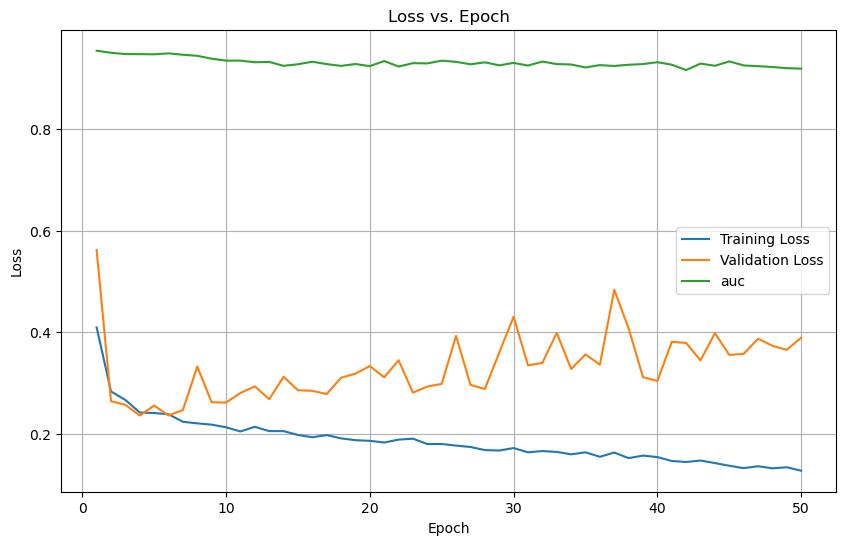

In [11]:
import matplotlib.pyplot as plt

# Plot Loss vs. Epoch
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_epoch, label='Training Loss')
plt.plot(epochs, test_loss_epoch, label='Validation Loss')
plt.plot(epochs, auc, label='auc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
val_loss, val_accuracy, val_auc = evaluate(model, test_loader, criterion, device)
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")

100%|███████████████████████████████████████████████████████████████████████████████| 1532/1532 [03:21<00:00,  7.60it/s]

Val Loss: 0.3079, Val Accuracy: 0.8944, Val AUC: 0.9573


In [13]:
len(test_loader.dataset)

6128